In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.transforms import v2
import torchvision

from model import Autoencoder
import numpy as np
from torchsummary import summary
import torch.utils.data as data

### Prepare input transforms and dataset

In [2]:
trans = v2.Compose([
    v2.Resize((32, 32)),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32, scale=True),
])

In [3]:
batch_size = 32
fmnist = torchvision.datasets.FashionMNIST(root='./f_mnist', train=True, download=True, transform=trans)
batched_data = data.DataLoader(dataset=fmnist, batch_size=batch_size, shuffle=True, num_workers=0)

### Define model

In [4]:
model = Autoencoder(img_size=32)
summary(model, (1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             320
              ReLU-2           [-1, 32, 16, 16]               0
            Conv2d-3             [-1, 64, 8, 8]          18,496
              ReLU-4             [-1, 64, 8, 8]               0
           Flatten-5                 [-1, 4096]               0
            Linear-6                   [-1, 10]          40,970
            Linear-7                 [-1, 4096]          45,056
         Unflatten-8             [-1, 64, 8, 8]               0
   ConvTranspose2d-9           [-1, 32, 16, 16]          32,800
             ReLU-10           [-1, 32, 16, 16]               0
  ConvTranspose2d-11            [-1, 1, 32, 32]             513
          Sigmoid-12            [-1, 1, 32, 32]               0
Total params: 138,155
Trainable params: 138,155
Non-trainable params: 0
-------------------------------

### Initialize parameters and hyperparameters

In [5]:
for params in model.parameters():
    if params.dim() > 1:
        torch.nn.init.xavier_uniform_(params)

optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)
loss_function = nn.MSELoss()

### Train model

In [10]:
epochs = 5
# training
for e in range(epochs):
    for batch in batched_data:
        optimizer.zero_grad()

        x = batch[0].to('cuda')
        y_hat = model(x)
        loss = loss_function(y_hat, x)
        loss.backward()
        optimizer.step()
        
        print(loss.item())
        

0.014255127869546413
0.012147955596446991
0.010123727843165398
0.011336919851601124
0.010945668444037437
0.01149263046681881
0.01156153529882431
0.014469645917415619
0.00998348742723465
0.010471126064658165
0.010984421707689762
0.010325266048312187
0.011674020439386368
0.01355479471385479
0.012058891355991364
0.008904351852834225
0.012089134193956852
0.011895841918885708
0.011559649370610714
0.01065470278263092
0.010842882096767426
0.011714779771864414
0.011540787294507027
0.010321000590920448
0.010599562898278236
0.009679075330495834
0.013387865386903286
0.010819806717336178
0.011622300371527672
0.009652381762862206
0.010946531780064106
0.013481887057423592
0.010830409824848175
0.011480776593089104
0.010855047032237053
0.010349256917834282
0.010361138731241226
0.012303074821829796
0.00957350991666317
0.00846981443464756
0.011138778179883957
0.01120324432849884
0.011298198252916336
0.013296069577336311
0.012406876310706139
0.012797660194337368
0.011276333592832088
0.011558140628039837


### Save model

In [ ]:
# torch.save(model.state_dict(), 'AE_10latents.pt')

### Test reconstruction

In [11]:
model.eval()
model.load_state_dict(torch.load('AE_10latents.pt'))

<All keys matched successfully>

In [8]:
rev_trans = v2.Compose([
    v2.Lambda(lambda t: (t * 255).astype(np.uint8)),
    v2.ToPILImage(),
])

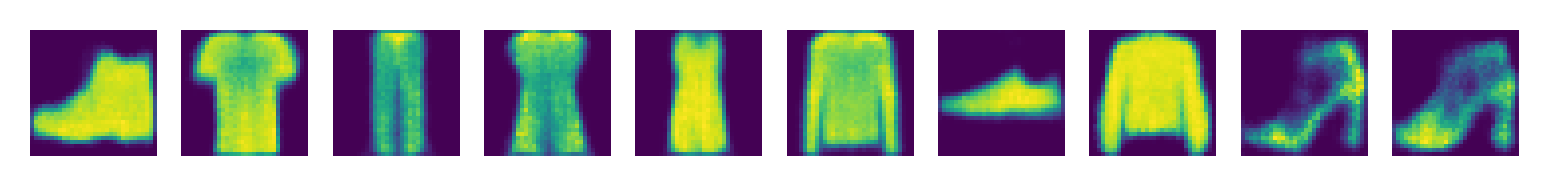

In [12]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 10, dpi=300)

for i in range(10):
    tmp_img = fmnist[i][0].to('cuda').unsqueeze(axis=0)
    pred = model(tmp_img).detach()
    img = rev_trans(pred.squeeze().cpu().numpy())
    
    ax[i].imshow(img)
    ax[i].axis('OFF')
plt.show()